## Using NEXRAD data from Amazon Web Services

Amazon has a cloud storage solution called Simple Storage Service or S3. S3 is a distributed store with very low latency (especially when compared to "shopping cart" systems like NCEI). http://docs.aws.amazon.com/AmazonS3/latest/dev/Welcome.html

There are many tools that can be used to interact with S3 stores or "Buckets". One tool in Python is Boto. 
From the website: http://boto3.readthedocs.io/en/latest/

"Boto is the Amazon Web Services (AWS) SDK for Python, which allows Python developers to write software that makes use of Amazon services like S3 and EC2. Boto provides an easy to use, object-oriented API as well as low-level direct service access."


In [26]:
#lets start with some imports

#Py-ART, simply the best sowftware around.. Give those guys a grant
import pyart

#Boto3 is the AWS SDK
import boto3

#botocore contains core configuration utilities for boto2 and boto3
from botocore.handlers import disable_signing

#Tempory files in Python.. A very useful module
import tempfile

#datetime modules.. very handy!
from datetime import datetime

#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop
import cartopy
%matplotlib inline



You can use Boto and S3 to store all kinds of data! open or closed. In fact Amazon has some very sophisticated methods to set rules.. But the real game changer for the radar community came with the CRADA between Amazon, NOAA and Unidata in putting all NEXRAD data into an S3 Bucket [1].


The NEXRAD Level II archive data is hosted in the “noaa-nexrad-level2” Amazon S3 bucket in S3’s US East region. The address for the public bucket is:

http://noaa-nexrad-level2.s3.amazonaws.com

https://noaa-nexrad-level2.s3.amazonaws.com

Each volume scan file is its own object in Amazon S3. The basic data format is the following:

`/<Year>/<Month>/<Day>/<NEXRAD Station>/<filename>`

All files in the archive use the same compressed format (.gz). The data file names are, for example, KAKQ20010101_080138.gz. The file naming convention is:

GGGGYYYYMMDD_TTTTTT

Where:

GGGG = Ground station ID (map of ground stations) YYYY = year MM = month DD = day TTTTTT = time when data started to be collected (GMT)

Note that the 2015 files have an additional field on the file name. It adds “_V06” to the end of the file name. An example is KABX20150303_001050_V06.gz.

In [2]:
# So we start with bucket neame
bucket = "noaa-nexrad-level2"
# Create a s3 "client"
s3 = boto3.resource('s3')
# Set it to unsigned 
s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)

In [3]:
#So now we connect to the bucket with the radar data
aws_radar = s3.Bucket(bucket)

Now.. indexing the whole bucket would be stupid.. lets do the math: 150 radars, ~6 files per hour, 15 (plus) years that's 324,000 files. Fortunately Boto has some nice indexing utilities. 

Buckets contain objects. The objects can be used to do and find out a whole bunch of things.. We are going to use the objects method of out bucket resource to only return objects from the 20th of may 2011 from the vance radar. 

In [4]:
for obj in aws_radar.objects.filter(Prefix='2011/05/20/KVNX/'):
    print('{0}:{1}'.format(aws_radar.name, obj.key))

noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_000023_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_000442_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_000901_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_001320_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_001740_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_002201_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_002620_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_003040_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_003459_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_003918_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_004338_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_004758_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_005219_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_005639_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_010100_V06.gz
noaa-nexrad-level2:2011/05/20/KVNX/KVNX20110520_010520_V06.gz
noaa-nex

We can also dump all the keys into a list

In [5]:
my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix='2011/05/20/KVNX/')]
print(my_list_of_keys[1])

2011/05/20/KVNX/KVNX20110520_000442_V06.gz


The strptime method of datetime provides a nice way to turn the stings (keys) into datetime objects.. We also make use of Python's exception handling systems for strings that do not match the pattern

In [6]:
#lets test it one one of the keys
my_datetime = datetime.strptime(my_list_of_keys[1][20:35], '%Y%m%d_%H%M%S')
print(my_datetime)

#now make an empty list to populated with the datetimes matching
my_list_of_datetimes = []

#loop over all the contents of the bucket with the prefix
for obj in aws_radar.objects.filter(Prefix='2011/05/20/KVNX/'):
    try:
        my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], '%Y%m%d_%H%M%S'))
    except ValueError:
        pass #usually a tar file left in the bucket


2011-05-20 00:04:42


Now we want to be able to search for a particular date time in the list.. This is a very handy helper function!

In [7]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [8]:
#lets see if we can find the key for 11Z on the 5th of may 2011
desired_time = datetime(2011,5,20,11,0)

#find the nearest datetime
my_nearest = nearest(my_list_of_datetimes, desired_time)

print('nearest: ', my_nearest, ' desired: ', desired_time)

#find the index of the nearest
print('index: ', my_list_of_datetimes.index(my_nearest))

#find the key of the nearest datetime
print('key: ', my_list_of_keys[my_list_of_datetimes.index(my_nearest)])


nearest:  2011-05-20 10:58:09  desired:  2011-05-20 11:00:00
index:  151
key:  2011/05/20/KVNX/KVNX20110520_105809_V06.gz


ALLRIGHT! Now lets take all we have learned to make a function that can search AWS S3 for the correct key for any radar and any date!  

In [11]:
def find_my_key(radar_name, desired_datetime):
    """
    Find the key in Amazon s3 corresponding to a particular radar site and 
    datetime
    
    Parameters
    ----------
    radar_name : str
        Four letter radar name
    desired_datetime : datetime
        The date time desired
    Returns
    -------
    my_key : string
        string matching the key for the radar file on AWS s3
    """
    
    bucket = "noaa-nexrad-level2"
    # Create a s3 "client"
    s3 = boto3.resource('s3')
    # Set it to unsigned 
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+radar_name)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix=target_string)]
    my_list_of_datetimes = []
    for obj in aws_radar.objects.filter(Prefix=target_string):
        try:
            my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], '%Y%m%d_%H%M%S'))
        except ValueError:
            pass #usually a tar file left in the bucket
    my_nearest = nearest(my_list_of_datetimes, desired_datetime)
    my_key = my_list_of_keys[my_list_of_datetimes.index(my_nearest)]
    return my_key


Lets take it for a spin!

In [41]:
print(find_my_key('KLOT', datetime(2011,1,1,20,15)))
print(find_my_key('KILX', datetime.utcnow()))
print(find_my_key('TJUA', datetime(2017,9,20,9,0)))


2011/01/01/KLOT/KLOT20110101_201844_V03.gz
2017/09/20/KILX/KILX20170920_150109_V06
2017/09/20/TJUA/TJUA20170920_085854_V06


Ok.. This is pretty boring! Where is the data?! Fortunately Boto3 makes it trivial to download the data with the method: 

```s3.Bucket.download_file(key, localfilename)```

But we do not want to play around with naming files and all that jazz so lets use Python's awesome tempfile module!

In [42]:
#Lets look at Hurricane Maria
maria_datetime = datetime(2017,9,20,9,0)

#grab the key for Maria
my_key = find_my_key('TJUA', maria_datetime)
print(my_key)

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
aws_radar.download_file(my_key, localfile.name)

#read that file into Py-ART!
radar = pyart.io.read(localfile.name)

2017/09/20/TJUA/TJUA20170920_085854_V06


In [43]:
#Sweep we want to plot
sweep = 0

#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Eastern')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

Wednesday September 20 at 04:58 AM EDT


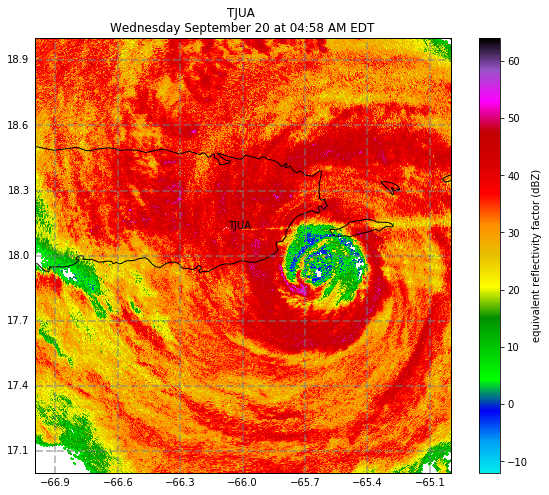

In [44]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=15, max_latitude=20)

title = 'TJUA \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=-67, max_lon=-65, min_lat=17, max_lat=19,
    vmin=-12, vmax=64, resolution='10m')

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='TJUA')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


[1] Ansari, S., S. Del Greco, E. Kearns, O. Brown, S. Wilkins, M. Ramamurthy, J. Weber, R. May, J. Sundwall, J. Layton, A. Gold, A. Pasch, and V. Lakshmanan, 0: Unlocking the potential of NEXRAD data through NOAA’s Big Data Partnership. Bull. Amer. Meteor. Soc., 0, https://doi.org/10.1175/BAMS-D-16-0021.1 